# Setup

In [1]:
ls

datalab/    sparsevgg16_weights.pt  vgg16_sparse_30.pt  y_s.bz2
drive/      vgg16_mask_50.pt        vgg16_sparse_40.pt
mask_s.bz2  vgg16_sparse_20.pt      X_s.bz2


In [0]:
#Giving colab permission to access drive

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#Note: if you get an error :  “apt-key output should not be parsed (stdout is not a terminal)” Warning
# it means that permission has been already granted

In [3]:
#Mount drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [118]:
# First to handle permmissions
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [119]:
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [120]:
# Lets get data!
folder_id = "1GDg2hJShtlXmFdTKgkv83nuvSLXCEnda"

file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
for file in file_list:
    download = drive.CreateFile({'id': file['id']})
    download.GetContentFile(file['title'])
    print('title: %s, id: %s' % (file['title'], file['id']))

title: vgg16_sparse_40.pt, id: 1nqk1igYK1rxep47d7EwG7NJEl7uYtROv
title: vgg16_sparse_30.pt, id: 1nK2RD59joFEqhW28a-k5WzAMMR_z0P_n
title: vgg16_sparse_20.pt, id: 1UqKof9dm-LWSmS3F7VQUf1Ti1hdsXH02
title: vgg16_mask_50.pt, id: 1GBSAoXlm7xvPFBj8beefsvrDDktKGOLI
title: sparsevgg16_weights.pt, id: 1kxcIoHS0HoN5RhbhQLxX5nX4GOqHFkmh
title: X_s.bz2, id: 1iOm4w67cW9dQPcuQGhySr6N_uEVvsig-
title: y_s.bz2, id: 1_VlZ-AxtC7fy5obbZXDOIV8m0l_dKR70
title: mask_s.bz2, id: 1pjM6437c5EsYQQf1xWlmq6PCFOccthH3


In [121]:
ls

datalab/    sparsevgg16_weights.pt  vgg16_sparse_30.pt  y_s.bz2
drive/      vgg16_mask_50.pt        vgg16_sparse_40.pt
mask_s.bz2  vgg16_sparse_20.pt      X_s.bz2


In [122]:
import os
os.chdir("drive/root/SBNet_pytorch/processed_VOC2012")

FileNotFoundError: ignored

In [6]:
ls

mask.bz2    vgg16_10_weights.pt  X.bz2    y.bz2
mask_s.bz2  VOC_DATA.csv         X_s.bz2  y_s.bz2


# Imports


In [2]:
import numpy as np

#pytorch
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install -q torchvision
import torch
print("pytorch version: ", torch.__version__)

pytorch version:  0.4.0


In [3]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np 
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import DataLoader 
import torch.nn.functional as F

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def reduce_mask_pool2d(mask, ksize, kstride, thresh = 0.2, avg= True, plot = False):
	'''
	Reduce mask operation:Takes a binary mask as input and after performing 
	avg pooling or max pooling selects active blocksand return indices of 
	the active blocks
	
	Inputs:
	:param mask:		torch tensor	#[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel
	:param thresh:		int 			#applicable for avg pooling
	:param avg:			bool 			#Avg pooling or max pooling 

	Require_grad = Fasle

	Output:
		indicies of size [B, 3] where B is the number of active blocks 
		and 3 corresponds to [N, y, x] where N is batch size, and (y,x) is the 
		co-ordinates of the "centre" of the block.
		indicies is a torch tensor
	Note:
		padding is done automatically
	'''

	assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
	isize = list(mask.size())
	assert len(mask.size()) == 3 , 'Expect input rank = 3'
	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
	assert type(thresh) in [int, float], 'Expect `thresh` to be int or float'

	mask = mask.unsqueeze(1)

	if avg:
		temp = F.avg_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
		indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
		if plot == True:
			plt.imshow(indicesm.cpu().detach().numpy())
		indices = (indicesm != 0).nonzero().to(device)
		return indices
	else:
		temp = F.max_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
		indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
		if plot == True:
			plt.imshow(indicesm.cpu().detach().numpy())
		indices = (indicesm != 0).nonzero().to(device)
		return indices

In [7]:
def pad_input(input, ksize, kstride):
	'''
	Pads the input or mask according to the required kernel to perform sparse convolution

	Inputs:
	:param input:		torch tensor	#[N,H,W] binary mask or [N,C,H,W] input, where N is batch diemension, W, H are width and height of mask and C is channels
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel

	Output: Zero padded torch tensor
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	isize = list(input.size())
	assert len(input.size()) == 3 or len(input.size()) == 4, 'Expect input rank = 3(mask) or 4(input)'
	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	#padding along width!
	pad_w = kstride[-1] - ((isize[-1]-ksize[-1])%kstride[-1])
	pad_w1 = pad_w2 = pad_w//2
	if pad_w%2 == 1:
		pad_w2 += 1

	#padding along height
	pad_h = kstride[-2] - ((isize[-2]-ksize[-2])%kstride[-2])
	pad_h1 = pad_h2 = pad_h//2
	if pad_h%2 == 1:
		pad_h2 += 1
	
	pad = (pad_w1, pad_w2, pad_h1, pad_h2)
	return F.pad(input, pad, "constant", 0).to(device)


In [8]:
def mask_pool2d(mask):
	'''
	mask downsample operation:Takes a binary mask as input and performs max
	pooling to reduce its size 
	
	Inputs:
	:param mask:		torch tensor	#[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask
	
	Outputs: A binary torch tensor of half the input mask size
	'''
	assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
	isize = list(mask.size())
	assert len(mask.size()) == 3 , 'Expect input rank = 3'

	mask = mask.unsqueeze(1)
	temp = F.max_pool2d(input = mask, kernel_size = [2,2], stride = [2,2], padding = 0).to(device).squeeze().float()
	temp.require_grad = False
	return temp


In [9]:
class gather2dc(nn.Module):
	def __init__(self, ksize, kstride):
		super(gather2dc, self).__init__()
		self.ksize = ksize
		self.kstride = kstride

	def forward(self, input, indices):
		gathered = input[indices[0][0]:indices[0][0]+1, :, indices[0][1]*self.kstride[0]:indices[0][1]*self.kstride[0]+self.ksize[0], indices[0][2]*self.kstride[1]: indices[0][2]*self.kstride[1]+self.ksize[1]]
		for B, h0, w0 in indices[1:]:
			gathered = torch.cat((gathered, input[B:B+1, :, h0*self.kstride[0]:h0*self.kstride[0]+self.ksize[0], w0*self.kstride[1]: w0*self.kstride[1]+self.ksize[1]]), 0)
		return gathered


class scatter2dc(nn.Module):
	def __init__(self, kstride):
		super(scatter2dc, self).__init__()
		self.kstride = kstride

	def forward(self, input, gathered, indices):
		gsize = list(gathered.size())
		count_index = 0
		inputn = input.clone()
		for B, h0, w0 in indices:
				inputn[B, :, h0*self.kstride[0]:h0*self.kstride[0]+gsize[2], w0*self.kstride[1]: w0*self.kstride[1]+gsize[3]] = gathered[count_index]
				count_index +=1
		return inputn

# Data

In [10]:
import pickle
import bz2

def save(name, to_save):
    sfile = bz2.BZ2File(name, 'w')
    pickle.dump(to_save, sfile)
    sfile.close()

def load(name):
    sfile = bz2.BZ2File(name, 'rb')
    data = pickle.load(sfile)
    sfile.close()
    return data

In [11]:
ls

datalab/    sparsevgg16_weights.pt  vgg16_sparse_30.pt  y_s.bz2
drive/      vgg16_mask_50.pt        vgg16_sparse_40.pt
mask_s.bz2  vgg16_sparse_20.pt      X_s.bz2


In [12]:
X_f = load("X_s.bz2")
y_f = load("y_s.bz2")
mask_f = load("mask_s.bz2")

In [13]:
X_test = X_f[0:120]
y_test = y_f[0:120]
mask_test = mask_f[0:120]

In [14]:
X_train = X_f[120:]
y_train = y_f[120:]
mask_train = mask_f[120:]

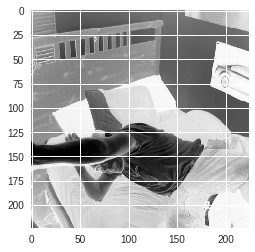

In [15]:
plt.imshow(X_train[1][2])

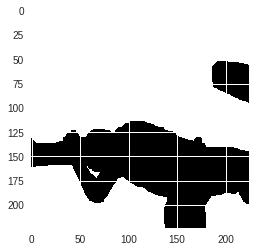

In [16]:
plt.imshow(mask_train[1])

In [17]:
print(X_train.shape, y_train.shape, mask_train.shape)

(1520, 3, 224, 224) (1520, 20) (1520, 224, 224)


In [18]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [19]:
def processy(y_train):
    for i in range(20):
        y_train[:, i] *= i
    y_train = y_train.sum(axis = 1)
    print(y_train.shape)
    y_train = torch.Tensor(y_train).to(device).to(torch.int64)
    return y_train
    


In [20]:
X_t = torch.FloatTensor(X_train).to(device)
y_t = processy(y_train)

mask_t = torch.FloatTensor(mask_train).to(device)
mask_t.requie_grad = False

mask_t_all = torch.ones_like(mask_t)

(1520,)


In [21]:
X_te = torch.FloatTensor(X_test).to(device)
y_te = processy(y_test)

mask_te = torch.FloatTensor(mask_test).to(device)
mask_te.requie_grad = False


(120,)


In [22]:
print(X_t.size())
print(y_t.size())
print(mask_t.size())

torch.Size([1520, 3, 224, 224])
torch.Size([1520])
torch.Size([1520, 224, 224])


In [23]:
print(X_te.size())
print(y_te.size())
print(mask_te.size())

torch.Size([120, 3, 224, 224])
torch.Size([120])
torch.Size([120, 224, 224])


Blocks in the model: 


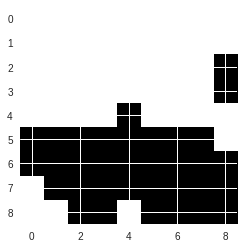

In [24]:
reduce_mask_pool2d(mask_t[1:1+1], [25,25], [23,23], thresh = 0.05 , plot = True)
print("Blocks in the model: ")

# Model Define

In [25]:
class sparse_block(nn.Module):
	def __init__(self, inp_ch, out_ch, ksize, kstride, block_layers = None, thresh = 0.2):
		super(sparse_block, self).__init__()

		assert type(block_layers) in [type(None), torch.nn.modules.container.Sequential], 'Expect block_layers as None or torch.nn.Sequential() object' 
		assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
		assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
		assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
		assert type(inp_ch) in [int, float], 'inp_ch should be int or float'
		assert type(out_ch) in [int, float], 'out_ch should be int or float'
		self.ksize = ksize
		self.kstride = kstride
		self.thresh = thresh
		self.gather = gather2dc(ksize, kstride)
		self.scatter = scatter2dc(kstride)
		self.channel_control =  nn.Sequential(
			nn.Conv2d(inp_ch, out_ch, 3, padding = 1),
			nn.BatchNorm2d(out_ch),
            nn.ReLU()).to(device)

		if block_layers == None:
			self.operation = nn.Sequential(
				nn.Conv2d(out_ch, 2*out_ch, 1, padding = 0),
				nn.ReLU(),
				nn.BatchNorm2d(2*out_ch),
				nn.Conv2d(2*out_ch, 2*out_ch, 3, padding = 1),
				nn.ReLU(),
				nn.BatchNorm2d(2*out_ch), #can be made as deep as required!
				nn.Conv2d(2*out_ch, out_ch, 1, padding = 0),
				nn.ReLU(),
				nn.BatchNorm2d(out_ch)
				).to(device)
		else:
			self.operation = block_layers.to(device)
			

	def forward(self, x, mask):
		x = self.channel_control(x)
		mask = pad_input(mask, self.ksize, self.kstride)
		mask.require_grad = False
		x = pad_input(x, self.ksize, self.kstride)
		x.require_grad = True

		indices = reduce_mask_pool2d(mask, self.ksize, self.kstride, self.thresh, avg= True)
		gathered = self.gather(x, indices)
		gathered = self.operation(gathered)

		x = self.scatter(x, gathered, indices)
		return x

In [26]:
       
def op_2conv(channel):
    return nn.Sequential(
        nn.Conv2d(channel, channel, 3, padding = 1),
        nn.BatchNorm2d(channel),
        nn.ReLU(),
    ).to(device)
    
        
def op_3conv(channel):
    return nn.Sequential(
        nn.Conv2d(channel, channel, 3, padding = 1),
        nn.BatchNorm2d(channel),
        nn.ReLU(),
        nn.Conv2d(channel, channel, 3, padding = 1),
        nn.BatchNorm2d(channel),
        nn.ReLU(),
    ).to(device)
        

![alt text](https://qph.ec.quoracdn.net/main-qimg-83c7dee9e8b039c3ca27c8dd91cacbb4)

In [27]:
class VGGSparse(nn.Module):
    def __init__(self, inp_ch, num_classes):
        super(VGGSparse, self).__init__()
        self.sparse1 = sparse_block(inp_ch, 64, [25,25], [23,23], thresh = 0.05, block_layers =op_2conv(64))
        self.mp1 = nn.MaxPool2d(2)
        self.sparse2 = sparse_block(64, 128, [20,20], [18,18], thresh = 0.05, block_layers =op_2conv(128))
        self.mp2 = nn.MaxPool2d(2)
        self.sparse3 = sparse_block(128, 256, [10,10], [9,9], thresh = 0.05, block_layers =op_3conv(256))
        self.mp3 = nn.MaxPool2d(2)
        self.sparse4 = sparse_block(256, 512, [5,5], [4,4], thresh = 0.05, block_layers =op_3conv(512))
        self.mp4 = nn.MaxPool2d(2)
        self.sparse5 = sparse_block(512, 512, [3,3], [2,2], thresh = 0.05, block_layers =op_3conv(512))
        self.mp5 = nn.MaxPool2d(2)
        self.fc = nn.Sequential(
            nn.Linear(512*9*9, 4096),
            nn.ReLU(),
            nn.Dropout(p =0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p =0.5),
            nn.Linear(4096, num_classes),
            nn.Softmax()
            #nn.Sigmoid()
            )
        #self.fc.register_backward_hook(savegrad)

    def forward(self, x, mask):
        x = self.sparse1(x, mask)
        x = self.mp1(x)
        mask = mask_pool2d(mask)
        
        x = self.sparse2(x, mask)
        x = self.mp2(x)
        mask = mask_pool2d(mask)
        
        x = self.sparse3(x, mask)
        x = self.mp3(x)
        mask = mask_pool2d(mask)
        
        x = self.sparse4(x, mask)
        x = self.mp4(x)
        mask = mask_pool2d(mask)
        
        x = self.sparse5(x, mask)
        x = self.mp5(x)
        #print(x.size())
        
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x
        
        

# Model Init 

In [28]:
num_epochs = 10
num_classes = 20
batch_size = 2
learning_rate = 0.005
img_channel, img_height, img_width = X_train.shape[1:]

In [29]:
model = VGGSparse(img_channel, num_classes).to(device)

In [30]:
model(X_t[0:batch_size], mask_t[0:batch_size]).size()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([2, 20])

In [26]:
model

VGGSparse(
  (sparse1): sparse_block(
    (gather): gather2dc()
    (scatter): scatter2dc()
    (channel_control): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (operation): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sparse2): sparse_block(
    (gather): gather2dc()
    (scatter): scatter2dc()
    (channel_control): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (operation): Sequential(
      (0): Conv2d(128, 128, kernel

# Trained by me and weights

In [0]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),    
        ).to(device)
        self.new = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=20, bias=True),
            nn.Softmax()
        ).to(device)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(batch_size, -1)
        x = self.new(x)
        return x
        

In [0]:
anand_dict = torch.load("vgg16_mask_50.pt")

In [41]:
print(len(model.state_dict()))
print(len(anand_dict["weight"]))

84
84


In [42]:
model.state_dict().keys()

odict_keys(['sparse1.channel_control.0.weight', 'sparse1.channel_control.0.bias', 'sparse1.channel_control.1.weight', 'sparse1.channel_control.1.bias', 'sparse1.channel_control.1.running_mean', 'sparse1.channel_control.1.running_var', 'sparse1.operation.0.weight', 'sparse1.operation.0.bias', 'sparse1.operation.1.weight', 'sparse1.operation.1.bias', 'sparse1.operation.1.running_mean', 'sparse1.operation.1.running_var', 'sparse2.channel_control.0.weight', 'sparse2.channel_control.0.bias', 'sparse2.channel_control.1.weight', 'sparse2.channel_control.1.bias', 'sparse2.channel_control.1.running_mean', 'sparse2.channel_control.1.running_var', 'sparse2.operation.0.weight', 'sparse2.operation.0.bias', 'sparse2.operation.1.weight', 'sparse2.operation.1.bias', 'sparse2.operation.1.running_mean', 'sparse2.operation.1.running_var', 'sparse3.channel_control.0.weight', 'sparse3.channel_control.0.bias', 'sparse3.channel_control.1.weight', 'sparse3.channel_control.1.bias', 'sparse3.channel_control.1.r

In [43]:
anand_dict["weight"].keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.20.weight', 'features.20.bias', 'features.21.weight', 'features.21.bias', 'features.21.running_mean', 'features.21.running_var', 'features.24.weight', 'features.2

In [45]:
#Copying weights

model_dict = model.state_dict()

rename = list(model.state_dict().keys())
renamed_dict = {}
z = 0 
for key, weights in anand_dict["weight"].items():
    a = key.split(".")[-1]
    b = rename[z].split(".")[-1]
    if(a == b):
        #model_dict[rename[z]] = weights
        print(model_dict[rename[z]].size(), weights.size())
        renamed_dict[rename[z]] = weights
        
    else:
        print("problem")
    z += 1
    #if z == 78:
    #    break
    #print(z)
   

torch.Size([64, 3, 3, 3]) torch.Size([64, 3, 3, 3])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64, 64, 3, 3]) torch.Size([64, 64, 3, 3])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([128, 64, 3, 3]) torch.Size([128, 64, 3, 3])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128, 128, 3, 3]) torch.Size([128, 128, 3, 3])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([256, 128, 3, 3]) torch.Size([256, 128, 3, 3])
torch.Size([256]) torc

In [0]:
model_dict.update(renamed_dict)
model.load_state_dict(renamed_dict, False)

In [0]:
model.state_dict()["sparse1.channel_control.0.weight"]
#weights loaded! yay :p

# Pretrained model and weights

In [35]:
model_pretrained = torchvision.models.vgg16_bn(pretrained=True)
model_pretrained

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [36]:
print(len(model.state_dict()))
print(len(model_pretrained.state_dict()))

84
84


In [37]:
model.state_dict().keys()

odict_keys(['sparse1.channel_control.0.weight', 'sparse1.channel_control.0.bias', 'sparse1.channel_control.1.weight', 'sparse1.channel_control.1.bias', 'sparse1.channel_control.1.running_mean', 'sparse1.channel_control.1.running_var', 'sparse1.operation.0.weight', 'sparse1.operation.0.bias', 'sparse1.operation.1.weight', 'sparse1.operation.1.bias', 'sparse1.operation.1.running_mean', 'sparse1.operation.1.running_var', 'sparse2.channel_control.0.weight', 'sparse2.channel_control.0.bias', 'sparse2.channel_control.1.weight', 'sparse2.channel_control.1.bias', 'sparse2.channel_control.1.running_mean', 'sparse2.channel_control.1.running_var', 'sparse2.operation.0.weight', 'sparse2.operation.0.bias', 'sparse2.operation.1.weight', 'sparse2.operation.1.bias', 'sparse2.operation.1.running_mean', 'sparse2.operation.1.running_var', 'sparse3.channel_control.0.weight', 'sparse3.channel_control.0.bias', 'sparse3.channel_control.1.weight', 'sparse3.channel_control.1.bias', 'sparse3.channel_control.1.r

In [38]:
model.state_dict()["sparse1.channel_control.0.weight"]

tensor([[[[ 0.1106,  0.0060,  0.0579],
          [ 0.1151,  0.1877, -0.0607],
          [-0.0177,  0.1891,  0.1729]],

         [[ 0.1549,  0.0102,  0.1708],
          [-0.0159,  0.1007, -0.0560],
          [-0.1165,  0.0636,  0.1914]],

         [[ 0.0542, -0.1147,  0.0946],
          [ 0.0416,  0.0306,  0.0932],
          [-0.0397, -0.1243, -0.0709]]],


        [[[ 0.1817, -0.1684,  0.0169],
          [ 0.1163, -0.0322,  0.0051],
          [-0.1708, -0.1404, -0.1816]],

         [[ 0.0626, -0.1243,  0.0553],
          [ 0.0766,  0.1586, -0.1750],
          [-0.0031,  0.0611,  0.0386]],

         [[ 0.1760,  0.0965,  0.0192],
          [-0.1267,  0.1766,  0.1098],
          [-0.1212,  0.0484,  0.0465]]],


        [[[-0.0403, -0.0128, -0.1442],
          [-0.1044, -0.0902, -0.1890],
          [-0.1740,  0.0033,  0.1513]],

         [[-0.0075, -0.0361,  0.0260],
          [-0.1229, -0.1787, -0.1056],
          [ 0.0780, -0.1145, -0.0882]],

         [[-0.1574, -0.0754, -0.1115],
     

In [39]:
model_pretrained.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.20.weight', 'features.20.bias', 'features.21.weight', 'features.21.bias', 'features.21.running_mean', 'features.21.running_var', 'features.24.weight', 'features.2

In [40]:
model_pretrained.state_dict()["features.0.weight"]

tensor([[[[ 8.2833e-02,  2.7968e-02,  7.7096e-02],
          [ 4.9341e-02, -3.3441e-02,  1.9572e-02],
          [ 8.0300e-02,  7.7076e-02,  8.3349e-02]],

         [[-4.4296e-02, -1.7748e-01, -4.8706e-02],
          [-1.1003e-01, -2.7530e-01, -1.3474e-01],
          [-5.9982e-03, -6.1375e-02,  1.6822e-02]],

         [[ 2.7480e-02, -6.6769e-02,  4.3955e-02],
          [-2.6662e-02, -1.4995e-01, -3.3615e-02],
          [ 5.2778e-02,  1.7143e-02,  8.6744e-02]]],


        [[[-1.2628e-02,  3.0218e-02, -2.6930e-02],
          [-1.3764e-02,  1.1993e-01, -6.6263e-03],
          [-2.6019e-02, -8.3535e-03, -3.9197e-02]],

         [[-4.0557e-02,  1.3983e-02, -5.4278e-02],
          [ 1.5412e-02,  1.8198e-01,  1.7598e-02],
          [-1.7032e-02,  1.1284e-02, -2.4226e-02]],

         [[-6.5683e-02,  5.9252e-02, -5.3020e-02],
          [ 3.8278e-02,  2.7292e-01,  5.9491e-02],
          [-4.1218e-02,  3.6159e-02, -3.0478e-02]]],


        [[[ 1.4962e-06, -1.1430e-06,  1.2536e-06],
          [-1.0

In [41]:
#Copying weights

model_dict = model.state_dict()
pretrained_dict = model_pretrained.state_dict()

rename = list(model.state_dict().keys())
renamed_dict = {}
z = 0 
for key, weights in pretrained_dict.items():
    a = key.split(".")[-1]
    b = rename[z].split(".")[-1]
    if(a == b):
        #model_dict[rename[z]] = weights
        print(model_dict[rename[z]].size(), weights.size())
        renamed_dict[rename[z]] = weights
        
    else:
        print("problem")
    z += 1
    if z == 78:
        break
    #print(z)
   

torch.Size([64, 3, 3, 3]) torch.Size([64, 3, 3, 3])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64, 64, 3, 3]) torch.Size([64, 64, 3, 3])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([128, 64, 3, 3]) torch.Size([128, 64, 3, 3])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128, 128, 3, 3]) torch.Size([128, 128, 3, 3])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([256, 128, 3, 3]) torch.Size([256, 128, 3, 3])
torch.Size([256]) torc

In [0]:
model_dict.update(renamed_dict)
model.load_state_dict(renamed_dict, False)

In [43]:
model.state_dict()["sparse1.channel_control.0.weight"]
#weights loaded! yay :p

tensor([[[[ 8.2833e-02,  2.7968e-02,  7.7096e-02],
          [ 4.9341e-02, -3.3441e-02,  1.9572e-02],
          [ 8.0300e-02,  7.7076e-02,  8.3349e-02]],

         [[-4.4296e-02, -1.7748e-01, -4.8706e-02],
          [-1.1003e-01, -2.7530e-01, -1.3474e-01],
          [-5.9982e-03, -6.1375e-02,  1.6822e-02]],

         [[ 2.7480e-02, -6.6769e-02,  4.3955e-02],
          [-2.6662e-02, -1.4995e-01, -3.3615e-02],
          [ 5.2778e-02,  1.7143e-02,  8.6744e-02]]],


        [[[-1.2628e-02,  3.0218e-02, -2.6930e-02],
          [-1.3764e-02,  1.1993e-01, -6.6263e-03],
          [-2.6019e-02, -8.3535e-03, -3.9197e-02]],

         [[-4.0557e-02,  1.3983e-02, -5.4278e-02],
          [ 1.5412e-02,  1.8198e-01,  1.7598e-02],
          [-1.7032e-02,  1.1284e-02, -2.4226e-02]],

         [[-6.5683e-02,  5.9252e-02, -5.3020e-02],
          [ 3.8278e-02,  2.7292e-01,  5.9491e-02],
          [-4.1218e-02,  3.6159e-02, -3.0478e-02]]],


        [[[ 1.4962e-06, -1.1430e-06,  1.2536e-06],
          [-1.0

In [44]:
#freezing layers
z =0
for param in model.parameters():
    #print(param)
    print(param.size())
    print("###################", z)
    if z >= 52:
        param.requires_grad = True
    else:
        param.requires_grad = False
    z += 1

torch.Size([64, 3, 3, 3])
################### 0
torch.Size([64])
################### 1
torch.Size([64])
################### 2
torch.Size([64])
################### 3
torch.Size([64, 64, 3, 3])
################### 4
torch.Size([64])
################### 5
torch.Size([64])
################### 6
torch.Size([64])
################### 7
torch.Size([128, 64, 3, 3])
################### 8
torch.Size([128])
################### 9
torch.Size([128])
################### 10
torch.Size([128])
################### 11
torch.Size([128, 128, 3, 3])
################### 12
torch.Size([128])
################### 13
torch.Size([128])
################### 14
torch.Size([128])
################### 15
torch.Size([256, 128, 3, 3])
################### 16
torch.Size([256])
################### 17
torch.Size([256])
################### 18
torch.Size([256])
################### 19
torch.Size([256, 256, 3, 3])
################### 20
torch.Size([256])
################### 21
torch.Size([256])
################### 22
torch.Size([2

# Continue train

In [31]:
anand_dict = torch.load("vgg16_sparse_40.pt")

In [32]:
print(len(model.state_dict()))
print(len(anand_dict["weight"]))

84
84


In [33]:
#Copying weights

model_dict = model.state_dict()

rename = list(model.state_dict().keys())
renamed_dict = {}
z = 0 
for key, weights in anand_dict["weight"].items():
    a = key.split(".")[-1]
    b = rename[z].split(".")[-1]
    if(a == b):
        #model_dict[rename[z]] = weights
        print(model_dict[rename[z]].size(), weights.size())
        renamed_dict[rename[z]] = weights
        
    else:
        print("problem")
    z += 1

torch.Size([64, 3, 3, 3]) torch.Size([64, 3, 3, 3])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64, 64, 3, 3]) torch.Size([64, 64, 3, 3])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([128, 64, 3, 3]) torch.Size([128, 64, 3, 3])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128, 128, 3, 3]) torch.Size([128, 128, 3, 3])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([256, 128, 3, 3]) torch.Size([256, 128, 3, 3])
torch.Size([256]) torc

In [34]:
model_dict.update(renamed_dict)
model.load_state_dict(renamed_dict)

In [35]:
model.state_dict()["sparse1.channel_control.0.weight"]
#weights loaded! yay :p

tensor([[[[ 0.1838,  0.1255,  0.0880],
          [-0.0287,  0.1636,  0.1587],
          [ 0.1476, -0.1576, -0.0076]],

         [[ 0.1061, -0.0773,  0.0760],
          [ 0.1404, -0.0493,  0.1872],
          [ 0.0391, -0.1456, -0.0914]],

         [[ 0.0007, -0.1435,  0.1694],
          [ 0.0184,  0.0858, -0.0879],
          [-0.1533,  0.0457,  0.0126]]],


        [[[-0.1573,  0.1231, -0.1429],
          [-0.0288,  0.1606,  0.1215],
          [-0.1890, -0.1142, -0.1370]],

         [[ 0.1268, -0.0157,  0.1791],
          [ 0.2038,  0.1799,  0.0547],
          [-0.1750,  0.0303, -0.1132]],

         [[ 0.1947, -0.0611, -0.1546],
          [ 0.0546, -0.0058, -0.0295],
          [-0.1088,  0.0974, -0.1076]]],


        [[[ 0.1696,  0.0582, -0.0516],
          [-0.1403, -0.0385, -0.1320],
          [-0.0334, -0.0552, -0.1711]],

         [[-0.0227,  0.0811,  0.0181],
          [ 0.1280, -0.1821, -0.1900],
          [ 0.1249,  0.1561,  0.1448]],

         [[-0.0796, -0.0869,  0.0420],
     

# Fine Tune 

In [36]:
cew = [0.04865211810012838,
 0.05131578947368422,
 0.047560975609756105,
 0.049807445442875485,
 0.05089858793324776,
 0.050609756097560986,
 0.04977535301668807,
 0.047143774069319654,
 0.05154043645699616,
 0.04993581514762517,
 0.05240693196405649,
 0.04788189987163031,
 0.05028883183568678,
 0.05099486521181002,
 0.04817073170731708,
 0.05125160462130938,
 0.05012836970474969,
 0.051444159178433896,
 0.04913350449293968,
 0.05105905006418486]

In [37]:
#criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(cew).to(device))
optimizer = optim.SGD(model.parameters(), lr = 0.0005)

In [79]:
optimizer.load_state_dict(anand_dict["opt"])

In [38]:
pwd

'/content'

In [39]:
#train
num_epochs = 20

for epoch in range(1, num_epochs+1):
    
    epoch_loss = 0
    print("\nEpoch = ", epoch)
    z = 0
        
    correct = 0
    total = 0
        
    for i in range(len(X_train)//batch_size):
        if i == (len(X_train)//batch_size) - 1:
            x = X_t[z:, :, :, :]
            y = y_t[z:]
            mask = mask_t[z:, :, :]
        else:
            x = X_t[z:z+batch_size, :, :, :]
            y = y_t[z:z+batch_size]
            mask = mask_t[z:z+batch_size, :, :]
            z += batch_size

        #Forward pass
        output = model(x, mask)
        loss = criterion(input = output, target = y)
        
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i%1 == 0:
            _, predicted = torch.max(output.data, 1)
            total += batch_size
            correct += (predicted == y ).sum().item()
            print('\rStep [{}/{}], Loss: {:.4f} , acc = {:.2f}%'.format(i, len(X_train)//batch_size, epoch_loss/(i+1), correct*100/total), end = ' ')
            if i % 100 == 0 and i != 0:
                pass
                #print(output[0])
                #print(y[0])
        #break
    '''
    if ctr < 2 :
        ctr += 1
    else:
        ctr = 0
    '''
    #break
    print("\nValidation:")
    z = 0
    total = 0
    correct = 0
    #validation accuracy 
    for i in range(len(X_test)//batch_size):
        if i == (len(X_test)//batch_size) - 1:
            x = X_te[z:, :, :, :]
            y = y_te[z:]
            mask = mask_te[z:, :, :]
        else:
            x = X_te[z:z+batch_size, :, :, :]
            y = y_te[z:z+batch_size]
            mask = mask_te[z:z+batch_size, :, :]
            z += batch_size
        
        output = model(x, mask)
        
        if i%1 == 0:
            _, predicted = torch.max(output.data, 1)
            total += batch_size
            correct += (predicted == y ).sum().item()
            print('\rStep [{}/{}] , acc = {:.2f}%'.format(i, len(X_train)//batch_size, correct*100/total), end = ' ')

        

import os
os.chdir("drive/")

state_dict = {"weight": model.state_dict(), "opt": optimizer.state_dict() }
torch.save(state_dict, "vgg16_sparse_60.pt")   

    


Epoch =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [759/760], Loss: 2.6182 , acc = 46.25% 
Validation:
Step [59/760] , acc = 59.17% 
Epoch =  2
Step [432/760], Loss: 2.6474 , acc = 43.19% 

Step [759/760], Loss: 2.6154 , acc = 46.45% 
Validation:
Step [59/760] , acc = 58.33% 
Epoch =  3
Step [566/760], Loss: 2.6223 , acc = 45.86% 

Step [759/760], Loss: 2.6162 , acc = 46.45% 
Validation:
Step [59/760] , acc = 59.17% 
Epoch =  4
Step [607/760], Loss: 2.6224 , acc = 45.72% 

Step [759/760], Loss: 2.6145 , acc = 46.51% 
Validation:
Step [59/760] , acc = 59.17% 
Epoch =  5
Step [620/760], Loss: 2.6183 , acc = 46.05% 

Step [636/760], Loss: 2.6173 , acc = 46.15% 

KeyboardInterrupt: ignored

In [47]:
pwd

'/content'

In [82]:
cd drive

/content/drive


In [83]:
state_dict = {"weight": model.state_dict(), "opt": optimizer.state_dict() }
torch.save(state_dict, "vgg16_sparse_40.pt")   

In [84]:
cd ..

/content


In [84]:
!ls -l --block-size=M

total 753M
-rw-r--r-- 1 root root   1M Jun 15 09:07 mask.bz2
-rw-r--r-- 1 root root   1M Jun 18 09:28 mask_s.bz2
-rw-r--r-- 1 root root   1M Jun 19 12:56 sparsevgg16_weights.pt
-rw-r--r-- 1 root root 513M Jun 19 09:16 vgg16_20_weights.pt
-rw-r--r-- 1 root root   1M Jun 15 09:07 VOC_DATA.csv
-rw-r--r-- 1 root root  57M Jun 15 09:10 X.bz2
-rw-r--r-- 1 root root 183M Jun 18 09:29 X_s.bz2
-rw-r--r-- 1 root root   1M Jun 15 09:07 y.bz2
-rw-r--r-- 1 root root   1M Jun 18 09:28 y_s.bz2
